In [7]:
# 📦 Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest

pd.set_option('display.max_columns', 100)
sns.set(style='whitegrid')


In [8]:
# 📂 Load the dataset (replace with your path if needed)
df = pd.read_csv('../data/mup_dme_ry25_p05_v10_dy22_rfrr.csv', low_memory=False)
df = df.copy()  # ensure safe modification
df.shape


(385637, 97)

In [9]:
# 🧹 Prepare simulation columns
df['COPD_Weight'] = df['Bene_CC_PH_COPD_V2_Pct'] / 100

# Simulate adjusted demand based on COPD weighting
df['Adjusted_Demand'] = df['DME_Tot_Suplr_Clms'] * (1 + df['COPD_Weight'])

# Add realistic random variation to simulate actual usage
np.random.seed(42)
df['Filters_Used'] = df['Adjusted_Demand'] * np.random.uniform(0.9, 1.1, size=len(df))

# Clean non-finite values before converting to int
df['Filters_Used'] = df['Filters_Used'].replace([np.inf, -np.inf], np.nan)
df = df.dropna(subset=['Filters_Used'])
df.loc[:, 'Filters_Used'] = df['Filters_Used'].round().astype(int)

df[['Filters_Used', 'COPD_Weight']].head()


,Filters_Used,COPD_Weight
15,435.0,0.004607
29,200.0,0.007586
36,944.0,0.001371
39,75.0,0.004783
40,395.0,0.003137


In [10]:
# 🧠 Anomaly Detection using Isolation Forest
features = df[['Filters_Used', 'COPD_Weight']].copy()

model = IsolationForest(n_estimators=100, contamination=0.05, random_state=42)
df['anomaly_score'] = model.fit_predict(features)

# Map result to labels
df['Anomaly'] = df['anomaly_score'].map({1: 'Normal', -1: 'Anomaly'})


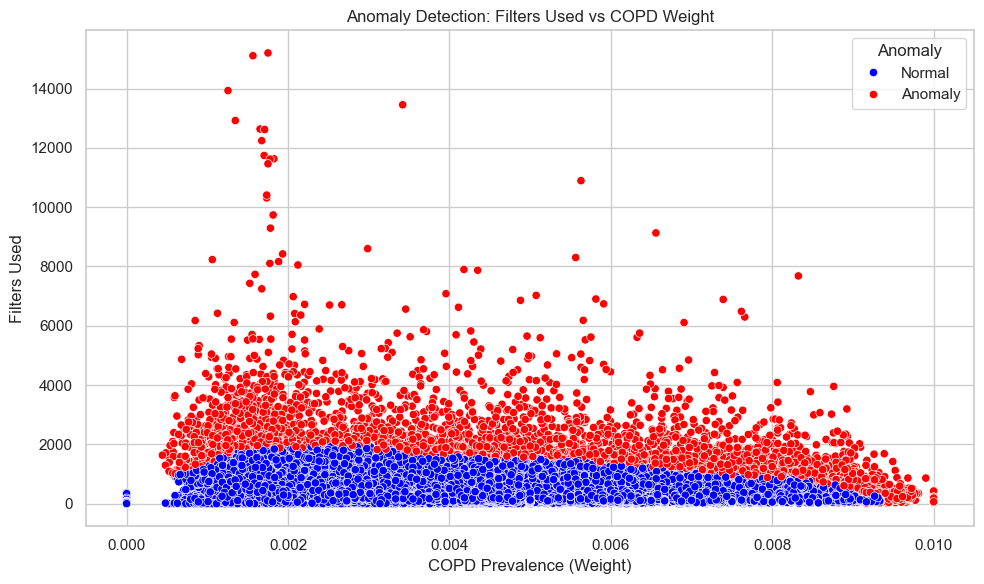

In [11]:
# 📊 Visualize anomalies
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df,
    x='COPD_Weight',
    y='Filters_Used',
    hue='Anomaly',
    palette={'Anomaly': 'red', 'Normal': 'blue'}
)
plt.title("Anomaly Detection: Filters Used vs COPD Weight")
plt.xlabel("COPD Prevalence (Weight)")
plt.ylabel("Filters Used")
plt.grid(True)
plt.tight_layout()
plt.show()
